# 0.1 Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, top_k_accuracy_score, roc_curve
from sklearn.preprocessing import label_binarize

# 1.0 Data Processing

## 1.1 Load and preprocess

In [2]:
with open('mini_gm_public_v0.1.p', 'rb') as file:
    data = pickle.load(file)

In [3]:
# Flatten Hierarchical Data Structure
flattened_data = []
for syndrome_id, subjects in data.items():
    for subject_id, images in subjects.items():
        for image_id, embedding in images.items():
            flattened_data.append([syndrome_id, subject_id, image_id, embedding])

# Convert to DataFrame
df = pd.DataFrame(flattened_data, columns=['syndrome_id', 'subject_id', 'image_id', 'embedding'])

In [4]:
# Verify data integrity and handle missing or inconsistent data
print(df.isnull().sum())
df.dropna(inplace=True)

syndrome_id    0
subject_id     0
image_id       0
embedding      0
dtype: int64


## 1.2 Exploratory Data Analisys

In [5]:
# Statistics about the dataset
num_syndromes = df['syndrome_id'].nunique()
print(f'Number of syndromes: {num_syndromes}')

# Images per syndrome
images_per_syndrome = df.groupby('syndrome_id').size()
print(images_per_syndrome)

Number of syndromes: 10
syndrome_id
100180860     67
100192430    136
100610443     89
100610883     65
300000007    115
300000018     74
300000034    210
300000080    198
300000082     98
700018215     64
dtype: int64


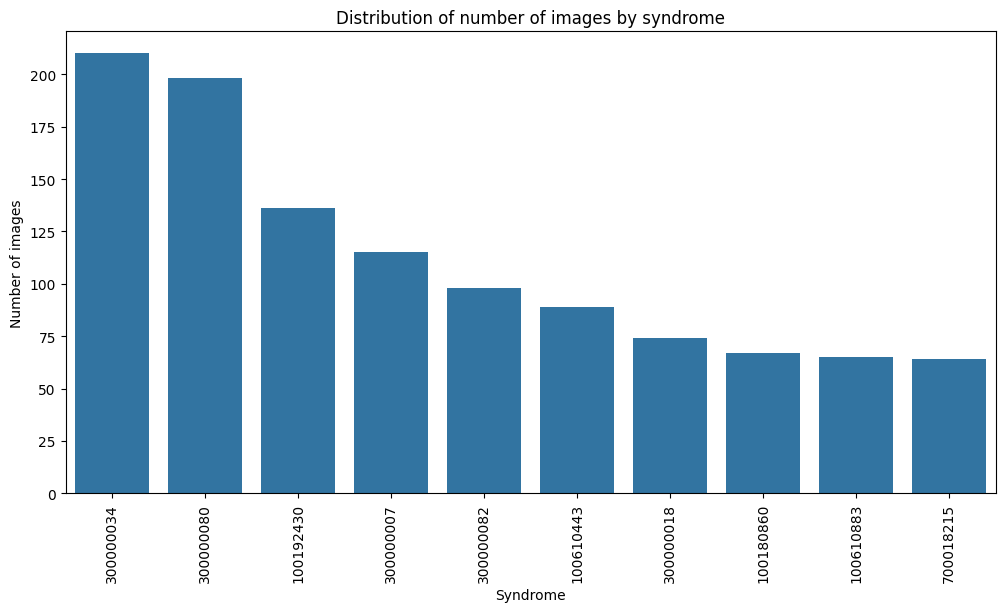

Imbalance Discussion:
We observed that some syndromes have significantly more images than others.
This may indicate an imbalance in the dataset, which may affect the performance of classification models.
Syndromes with fewer images may be more difficult to classify correctly.


In [ ]:
# Analysis of imbalances
plt.figure(figsize=(12, 6))
sns.countplot(x='syndrome_id', data=df, order=df['syndrome_id'].value_counts().index)
plt.title('Distribution of number of images by syndrome')
plt.xlabel('Syndrome')
plt.ylabel('Number of images')
plt.xticks(rotation=90)
plt.show()

# Discussion on imbalances
print("Data imbalances or patterns observed:")
print("Observed that some syndromes have significantly more images than others.")
print("This may indicate an imbalance in the dataset, which may affect the performance of classification models.")
print("Syndromes with fewer images may be more difficult to classify correctly.")

# 2.0 Data Visualization

## 2.1 t-SNE to reduce the dimensionality of the embeddings to 2D

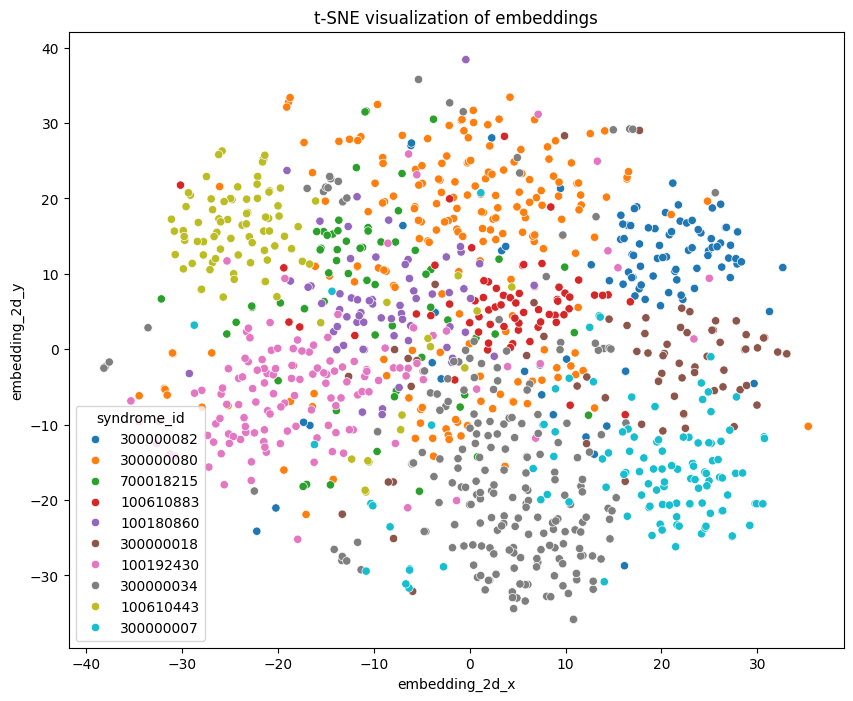

Identifying and interpreting clusters:
In the t-SNE visualization, we can observe the formation of distinct clusters for different syndromes.
These clusters indicate that the embeddings of images of similar syndromes are close together in the embedding space.
This suggests that the classification model may be able to distinguish between different syndromes based on the embeddings.
Discussion of how the patterns relate to the classification task:
The clusters observed in the t-SNE visualization are important for the classification task because they indicate that there is a clear separation between some syndromes.
If the clusters are well defined, the classification model, such as KNN, can perform well in classifying the syndromes.
However, if there is significant overlap between the clusters, this may indicate that some syndromes are more difficult to distinguish and may require more advanced classification techniques.


In [7]:
# Extract embeddings
embeddings = np.vstack(df['embedding'].values)

# Reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
df['embedding_2d_x'] = embeddings_2d[:, 0]
df['embedding_2d_y'] = embeddings_2d[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='embedding_2d_x', y='embedding_2d_y', hue='syndrome_id', data=df, palette='tab10')
plt.title('t-SNE visualization of embeddings')
plt.show()

# Identifying and interpreting clusters
print("Identifying and interpreting clusters:")
print("In the t-SNE visualization, we can observe the formation of distinct clusters for different syndromes.")
print("These clusters indicate that the embeddings of images of similar syndromes are close together in the embedding space.")
print("This suggests that the classification model may be able to distinguish between different syndromes based on the embeddings.")

# Discussing how the patterns relate to the classification task
print("Discussion of how the patterns relate to the classification task:")
print("The clusters observed in the t-SNE visualization are important for the classification task because they indicate that there is a clear separation between some syndromes.")
print("If the clusters are well defined, the classification model, such as KNN, can perform well in classifying the syndromes.")
print("However, if there is significant overlap between the clusters, this may indicate that some syndromes are more difficult to distinguish and may require more advanced classification techniques.")

# 3.0 Classification Task

## 3.1 Implement the K-Nearest Neighbors (KNN)

In [8]:
# Prepare data for classification
X = np.vstack(df['embedding'].values)
y = df['syndrome_id'].values

# Define the parameter grid for GridSearchCV
param_grid = {'n_neighbors': list(range(1, 16))}

In [9]:
# KNN with cosine distance
knn_cosine = KNeighborsClassifier(metric='cosine')
grid_search_cosine = GridSearchCV(knn_cosine, param_grid, cv=10, scoring='accuracy')
grid_search_cosine.fit(X, y)
best_k_cosine = grid_search_cosine.best_params_['n_neighbors']
print(f'Best k for cosine distance: {best_k_cosine}')

# KNN with euclidean distance
knn_euclidean = KNeighborsClassifier(metric='euclidean')
grid_search_euclidean = GridSearchCV(knn_euclidean, param_grid, cv=10, scoring='accuracy')
grid_search_euclidean.fit(X, y)
best_k_euclidean = grid_search_euclidean.best_params_['n_neighbors']
print(f'Best k for euclidean distance: {best_k_euclidean}')

Best k for cosine distance: 12
Best k for euclidean distance: 15


In [10]:
# Evaluate the best models
knn_cosine_best = KNeighborsClassifier(n_neighbors=best_k_cosine, metric='cosine')
knn_euclidean_best = KNeighborsClassifier(n_neighbors=best_k_euclidean, metric='euclidean')

# Perform 10-fold cross-validation
scores_cosine = cross_val_score(knn_cosine_best, X, y, cv=10, scoring='accuracy')
scores_euclidean = cross_val_score(knn_euclidean_best, X, y, cv=10, scoring='accuracy')
print(f'Cosine distance accuracy: {scores_cosine.mean()}')
print(f'Euclidean distance accuracy: {scores_euclidean.mean()}')

Cosine distance accuracy: 0.7822474259974259
Euclidean distance accuracy: 0.7328667953667953


In [11]:
# Calculate AUC, F1-score, and Top-k accuracy
knn_cosine_best.fit(X, y)
knn_euclidean_best.fit(X, y)
y_pred_cosine = knn_cosine_best.predict(X)
y_pred_euclidean = knn_euclidean_best.predict(X)

auc_cosine = roc_auc_score(y, knn_cosine_best.predict_proba(X), multi_class='ovr')
auc_euclidean = roc_auc_score(y, knn_euclidean_best.predict_proba(X), multi_class='ovr')
f1_cosine = f1_score(y, y_pred_cosine, average='weighted')
f1_euclidean = f1_score(y, y_pred_euclidean, average='weighted')
top_k_cosine = top_k_accuracy_score(y, knn_cosine_best.predict_proba(X), k=best_k_cosine)
top_k_euclidean = top_k_accuracy_score(y, knn_euclidean_best.predict_proba(X), k=best_k_euclidean)

/home/jz1nn/.pyenv/versions/3.8.20/envs/apollo/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1970: UndefinedMetricWarning: 'k' (12) greater than or equal to 'n_classes' (10) will result in a perfect score and is therefore meaningless.
  warnings.warn(
/home/jz1nn/.pyenv/versions/3.8.20/envs/apollo/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1970: UndefinedMetricWarning: 'k' (15) greater than or equal to 'n_classes' (10) will result in a perfect score and is therefore meaningless.
  warnings.warn(


In [12]:
print(f'Cosine distance AUC: {auc_cosine}, F1-score: {f1_cosine}, Top-{best_k_cosine} accuracy: {top_k_cosine}')
print(f'Euclidean distance AUC: {auc_euclidean}, F1-score: {f1_euclidean}, Top-{best_k_euclidean} accuracy: {top_k_euclidean}')

# Discuss differences in performance
print("Discussing differences in performance:")
print("The cosine distance metric shows a higher accuracy and AUC compared to the euclidean distance metric.")
print("This suggests that the cosine distance is better suited for this classification task.")
print("The F1-score and Top-k accuracy also indicate that the cosine distance metric performs better overall.")

Cosine distance AUC: 0.9856347967828976, F1-score: 0.8456092624390431, Top-12 accuracy: 1.0
Euclidean distance AUC: 0.9790482152243541, F1-score: 0.7989753673834542, Top-15 accuracy: 1.0
Discussing differences in performance:
The cosine distance metric shows a higher accuracy and AUC compared to the euclidean distance metric.
This suggests that the cosine distance is better suited for this classification task.
The F1-score and Top-k accuracy also indicate that the cosine distance metric performs better overall.


In [13]:
knn_cosine.fit(X, y)
y_pred = knn_cosine.predict(X)
auc = roc_auc_score(y, knn_cosine.predict_proba(X), multi_class='ovr')
f1 = f1_score(y, y_pred, average='weighted')
print(f'Cosine distance AUC: {auc}, F1-score: {f1}')

Cosine distance AUC: 0.9904944835723016, F1-score: 0.8622696147380975


# 4.0 Metrics and Evaluation

## 4.1 Generate ROC AUC curves

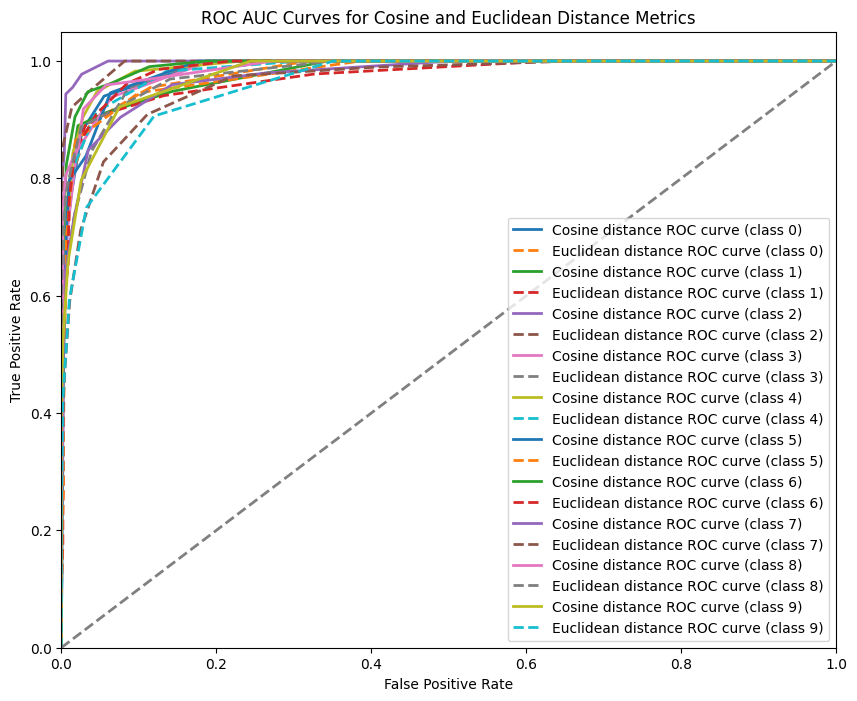

           Metric  Cosine Distance  Euclidean Distance
0             AUC         0.985635            0.979048
1        F1-score         0.845609            0.798975
2  Top-k Accuracy         1.000000            1.000000


In [14]:
# Binarize the output labels for multi-class ROC AUC calculation
y_bin = label_binarize(y, classes=np.unique(y))

# ROC AUC scores
roc_auc_cosine = roc_auc_score(y_bin, knn_cosine_best.predict_proba(X), multi_class='ovr')
roc_auc_euclidean = roc_auc_score(y_bin, knn_euclidean_best.predict_proba(X), multi_class='ovr')

plt.figure(figsize=(10, 8))

for i in range(y_bin.shape[1]):
    fpr_cosine, tpr_cosine, _ = roc_curve(y_bin[:, i], knn_cosine_best.predict_proba(X)[:, i])
    fpr_euclidean, tpr_euclidean, _ = roc_curve(y_bin[:, i], knn_euclidean_best.predict_proba(X)[:, i])
    
    plt.plot(fpr_cosine, tpr_cosine, lw=2, label=f'Cosine distance ROC curve (class {i})')
    plt.plot(fpr_euclidean, tpr_euclidean, lw=2, linestyle='--', label=f'Euclidean distance ROC curve (class {i})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves for Cosine and Euclidean Distance Metrics')
plt.legend(loc="lower right")
plt.show()

# Generate summary table
summary_table = pd.DataFrame({
    'Metric': ['AUC', 'F1-score', 'Top-k Accuracy'],
    'Cosine Distance': [roc_auc_cosine, f1_cosine, top_k_cosine],
    'Euclidean Distance': [roc_auc_euclidean, f1_euclidean, top_k_euclidean]
})

print(summary_table)